In [1]:
import importlib
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pkg import plot_twin_lines
import os
os.chdir("/Users/caropark/FAO_ag_check_code/")
plt.rcParams.update({'font.size': 22})

In [2]:
combined = pd.read_csv("./data/yields.csv")

maize_18 = (combined.query("cropname == 'Maize' and `yield_log_dt` == `yield_log_dt`") 
    .assign(counts=lambda d: d.groupby('iso_a3')['iso_a3'].transform('size'))
    .query("counts > 17")
    .copy()
    .rename(columns={"year": 'Year'}))

corrdf = maize_18.groupby(['country', 'iso_a3']).apply(lambda d:pd.Series(stats.pearsonr(d['csif_log_dt'], d['yield_log_dt']),
                                                                           index=["corr", "pval"])).reset_index()
corrdf = corrdf.assign(pval= lambda d: round(d['pval'], 4),
                       **{"abs(corr)": lambda d: abs(d['corr'])})

#corr_idx = corrdf.sort_values("abs(corr)").reset_index()[['country', 'iso_a3']]
corr_idx = corrdf.sort_values("corr").reset_index()[['country', 'iso_a3']]

flags = (pd.read_csv("./data/faostat_all_flags.csv")[lambda df: df['Flag Description'] == "Estimated value"]
       .query("cropname == 'Maize' "))[['iso_a3', 'country', 'Year', 'cropname']].rename({"Year":"year"}, axis=1).drop_duplicates()
flags['flag'] = pd.to_numeric(1)


True


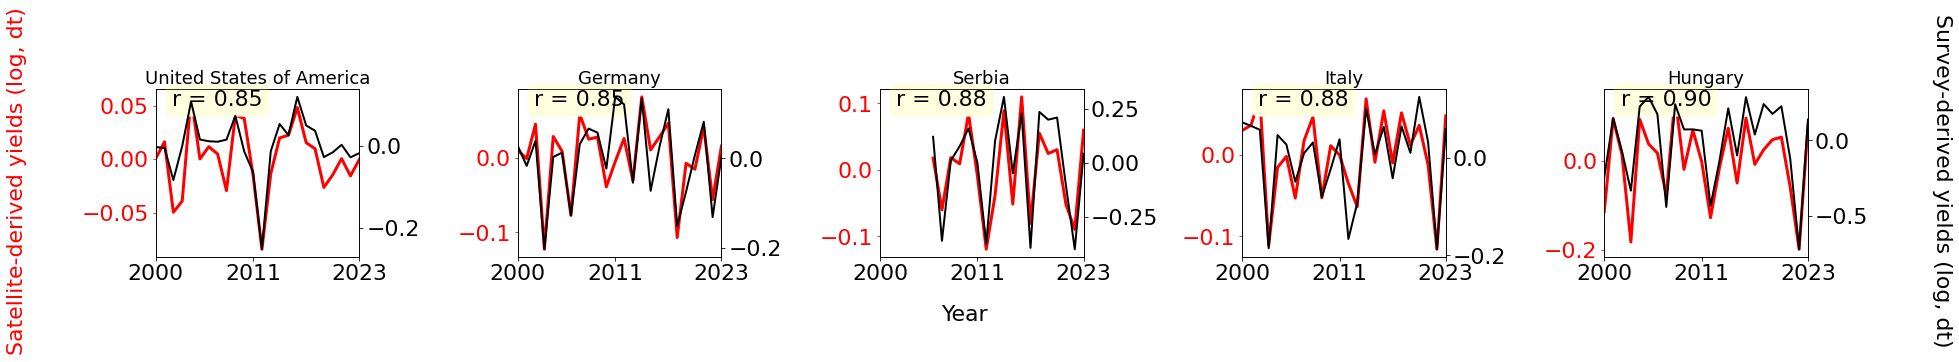

In [3]:
df = maize_18[maize_18['iso_a3'].isin(corr_idx.iloc[-5:,1])]
flags_best = flags[flags['iso_a3'].isin(corr_idx.iloc[-5:,1])]
print(flags_best.empty)

plot_twin_lines(df, col="country", col_wrap = 5, col_order = corr_idx.iloc[-5:,0], grid_kwargs=None, plot_kwargs={'color': "red"}, filename="global_maize_best_ts.pdf")

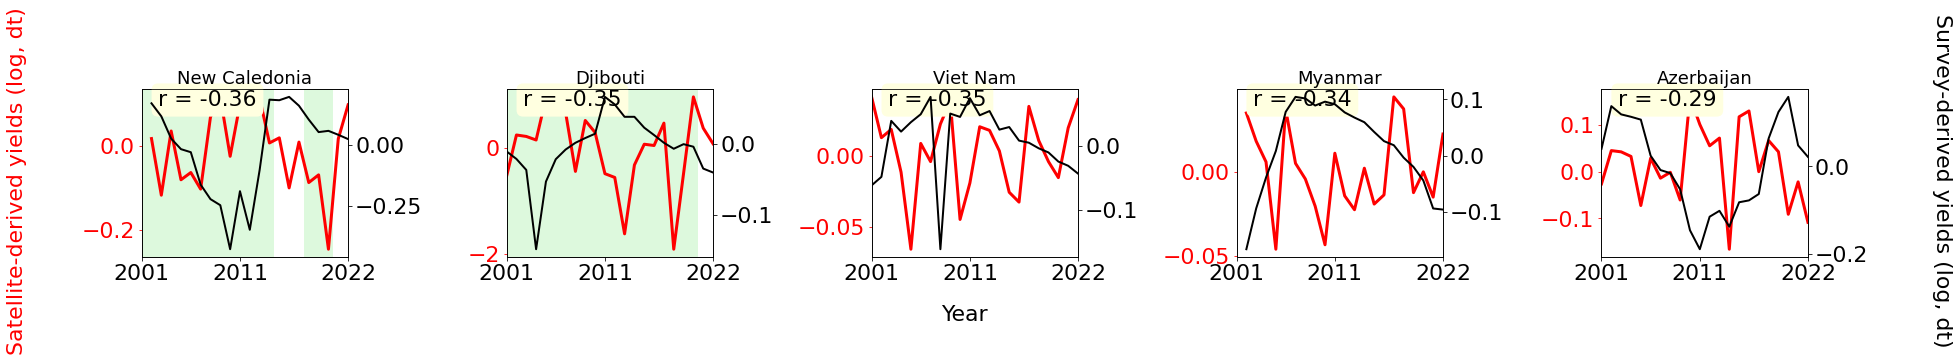

In [14]:
df = maize_18[maize_18['country'].isin(corr_idx.iloc[:5,0])]
flags_worst = flags[flags["iso_a3"].isin(corr_idx.iloc[:5,1])]
flags_worst.groupby('iso_a3')[['year']].agg([min, max, len])
fl = flags_worst[["country", 'year']].values.tolist()

plot_twin_lines(df, col="country", col_wrap = 5, col_order = corr_idx.iloc[:5,0], grid_kwargs=None, plot_kwargs={'color': "red"}, 
                filename="global_maize_worst_ts.pdf", fl=fl)


In [31]:
# og = pd.read_csv("./data/yields.csv")

# maize_18 = (og.query("cropname == 'Maize' and `yield_log_dt` == `yield_log_dt`") 
#         .assign(counts=lambda d: d.groupby('iso_a3')['iso_a3'].transform('size'))
#         .query("counts > 17").copy().rename(columns={"year": 'Year'}))

# ## sort by correlation
# corrdf = maize_18.groupby(['country', 'iso_a3']).apply(lambda d:pd.Series(stats.pearsonr(d['csif_log_dt'], d['yield_log_dt']),
#                                                                         index=["corr", "pval"])).reset_index()
# corrdf = corrdf.assign(pval= lambda d: round(d['pval'], 4), **{"abs(corr)": lambda d: abs(d['corr'])})
# corr_idx = corrdf.sort_values("corr").reset_index()[['country', 'iso_a3']]

# print(corr_idx.iloc[:5,0])
# maize_18[maize_18['country'].isin(corr_idx.iloc[:5,0])]


In [32]:
# og_na = pd.read_csv("./data/yields.csv").dropna()
# og = pd.read_csv("./data/yields.csv")